In [1]:
# import stuff based on the provided assignments

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select
from pprint import pprint

[2021-12-04 13:43:43][datar][WARNING] Builtin name "filter" has been overriden by datar.


In [50]:
"""function for testing frequencies and different strikes for all worksheets"""

def read_data(xls,worksheet):
    return pd.read_excel(xls, worksheet)
    

def format_data(df,expiry):
    """Convert into correct format"""
    df.rename(dict(zip(np.append(np.array(df.columns[0]), df.columns[-3:]), ['T', 'S', 'r', 'date'])), axis='columns', inplace=True)
    df = df.melt(id_vars=['T', 'r', 'S', 'date'], var_name="E").dropna()
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['name'] = df['E'].astype('str') + '-' + expiry
    
    df.rename({'value':'Cobs'}, axis='columns', inplace=True)
    df = df  >> mutate(r = f.r/100, Mat = f.T, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)
    df['Mat'] = df['Mat'].astype('int')
    
    return df
    
def calculate_bs_greeks(row):
    """Calculate IV and using that as volatility find delta and vega"""
    S=row['S']
    E=row['E']
    r=row['r']
    T=row['T']
    Cobs=row['Cobs']
    
    starting_vol = .2
    bsm = BSM(S, E, T, r, starting_vol)
    iv = bsm.implied_vol(Cobs, precision=1.0e-6)
    
    bsm_iv = BSM(S, E, T, r, iv)
    
    delta = bsm_iv.delta()
    vega = bsm_iv.vega()
    
    return iv, delta, vega

def hedge(p_o, p_s, cobs, S, delta):
    option_gain = cobs - p_o
    stock_gain = -delta * (S - p_s['price'])
    error = option_gain + stock_gain
    
    return cobs, {'price':S, 'delta':delta}, error**2

def calculate_sheet_greeks(excel, sheet_name, sheetnr):
    day = str(sheet_name[3:5])
    month = str(sheet_name[5:7])
    year = str(sheet_name[7:11])
    expiry=year+month+day

    
    df = format_data(read_data(xls, sheet_name), expiry)
    greeks = df.apply(calculate_bs_greeks, axis=1, result_type='expand')
    df[['iv', 'delta', 'vega']] = greeks
    df['sheet'] = sheet_name
    df = df >> filter(0 < f.iv < 0.9)
    
    return df



In [51]:
xls = pd.ExcelFile('data/isx2010C.xls')
sheets = xls.sheet_names

sheet_order = [0,1,11,10,9,8,7,6,5,4,3,2]

all_sheets = []

for i in sheet_order:
    df = calculate_sheet_greeks(xls, sheets[i], i)
    all_sheets.append(df)

all_data = pd.concat(all_sheets)

/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
  + (self.r + 0.5 * self.sigma ** 2) * self.T
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
  vol = vol + diff / opt.vega()
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
  self.d1 = (
/home/juuso/Documents/school/finaeng1/venv/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars
  vol = vol + diff / opt.vega()


In [52]:
all_data

,T,r,S,date,E,Cobs,name,Mat,iv,delta,vega,sheet
,<float64>,<float64>,<float64>,<datetime64[ns]>,<object>,<float64>,<object>,<int64>,<float64>,<float64>,<float64>,<object>
0,0.341270,0.0011,0.49134,2009-09-21,0.34,0.15220,340-20100115,86,0.322557,0.979826,0.014000,isx15012010C
1,0.337302,0.0011,0.49435,2009-09-22,0.34,0.15505,340-20100115,85,0.316441,0.983437,0.011838,isx15012010C
2,0.333333,0.0011,0.49036,2009-09-23,0.34,0.15240,340-20100115,84,0.386955,0.960153,0.024321,isx15012010C
4,0.325397,0.0011,0.48411,2009-09-25,0.34,0.14555,340-20100115,82,0.354207,0.967964,0.019839,isx15012010C
...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.321429,0.0011,0.49169,2009-09-28,0.34,0.15280,340-20100115,81,0.350097,0.974979,0.016304,isx15012010C
8005,0.019841,0.0014,0.55781,2010-12-13,0.56,0.00310,560-20101217,5,0.130409,0.419718,0.030709,isx17122010C
8006,0.015873,0.0014,0.55864,2010-12-14,0.56,0.00245,560-20101217,4,0.109453,0.433362,0.027686,isx17122010C
8007,0.011905,0.0014,0.55623,2010-12-15,0.56,0.00130,560-20101217,3,0.114676,0.297266,0.021014,isx17122010C


In [60]:
all_options = all_data['name'].unique()
observations = []
freq_min = 1
freq_max = 6
for option in all_options:
    for freq in range(freq_min, freq_max):
    
        option_data = all_data[all_data['name'] == option]
        option_data['stock_amount'] = -option_data.iloc[::freq,:]['delta']
        option_data['stock_amount']=option_data['stock_amount'].ffill()
        
        option_data['option_return'] = option_data['Cobs'].diff()
        option_data['stock_return'] = option_data['stock_amount'].shift(1) * (option_data['S'].diff())
        option_data['portfolio_return'] = option_data['stock_return'] + option_data['option_return']


        s_start = option_data['S'].iloc[0]
        s_end = option_data['S'].iloc[-1]
        s_mean = option_data['S'].mean()
        strike = option_data['E'].iloc[0]
        mse = (option_data['portfolio_return'] ** 2).mean()
        sheet = option_data['sheet'].unique()[0]
        observations.append([option, s_start, s_end, s_mean,strike, mse, freq, sheet])

/tmp/ipykernel_2760/3379518144.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['stock_amount'] = -option_data.iloc[::freq,:]['delta']
/tmp/ipykernel_2760/3379518144.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['stock_amount']=option_data['stock_amount'].ffill()
/tmp/ipykernel_2760/3379518144.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

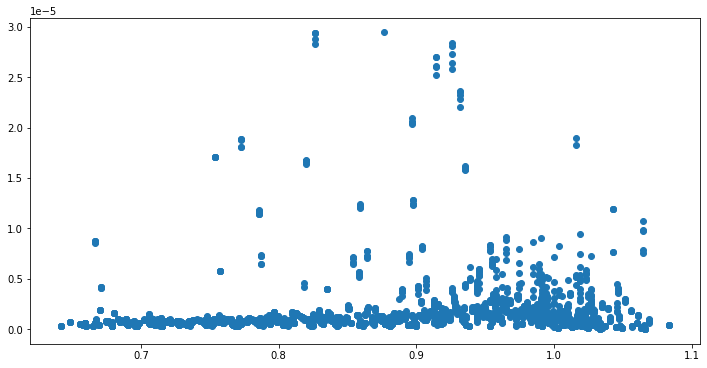

In [61]:
obs_df = pd.DataFrame(observations, columns = ['name', 'S_start', 'S_end', 'S_mean', 'E', 'mse', 'freq', 'sheet'])
obs_df = obs_df >> filter(f.mse < 3e-5)
obs_df['moneyness'] = obs_df['E'] / obs_df['S_mean']

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(obs_df['moneyness'], obs_df['mse'])
plt.show()

In [62]:
import statsmodels.api as sm

reg = obs_df.copy()

freq_dummy = pd.get_dummies(reg['freq'],prefix='freq')
sheet_dummy = pd.get_dummies(reg['sheet'], prefix='sheet')

reg_df = pd.concat([reg, freq_dummy, sheet_dummy], axis=1)
X = reg_df[['moneyness'] + list(freq_dummy.columns) + list(sheet_dummy.columns)]
y = reg_df['mse']

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mse   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     20.20
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.40e-55
Time:                        14:49:05   Log-Likelihood:                 28527.
No. Observations:                2533   AIC:                        -5.702e+04
Df Residuals:                    2516   BIC:                        -5.692e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.473e-07   3.69